In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
from scipy import stats
from tqdm import tqdm

In [2]:
#Reading Data
inputFile = "MAESTRO-d6178bdd-identified_variants_merged_protein_regions-main.tsv"
data = pd.read_csv(inputFile,sep='\t',low_memory=False)

In [3]:
#Preprocessing the Data
data_processed = data[['Peptide'] + [c for c in data.columns if 'intensity_for_peptide_variant' in c]]
data_processed.replace(0.0,np.nan, inplace = True)
data_processed = data_processed.set_index("Peptide")
data_processed = data_processed.T
data_processed.index = data_processed.index.map(lambda x:'.'.join(x.split('.')[:2]))

/home/aditya/.local/lib/python3.8/site-packages/pandas/core/frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [4]:
#Create Label
def create_label(x):
    if "#Healthy" in x:
        return 1
    elif "#Non-severe-COVID-19" in x:
        return 2
    elif "#Severe-COVID-19" in x:
        return 3
    elif "#Symptomatic-non-COVID-19" in x:
        return 4
    else:
        return 0
data_processed["label"]=data_processed.index.map(lambda x: create_label(x))
data_processed = data_processed[data_processed['label']!=0]

In [5]:
#Split Train and Test data after shuffling 
data_processed = data_processed.sample(frac=1, random_state=42)
data_processed.dropna(axis=1,inplace=True)

train = data_processed.iloc[:66,:]
test = data_processed.iloc[66:,:]

In [6]:
##Filter Data based on NaN for each label in training data

# per_label_count = train.groupby('label').count()
# filterCondition = (per_label_count >= 13).all()
# filter_per_label = per_label_count.loc[:, filterCondition]
# filter_column = list(filter_per_label.columns) +['label']
# filter_data =  train[filter_column]

# for column in tqdm(filter_data):
#     if column != "label":
#         filter_data[column] = filter_data.groupby("label")[column].transform(lambda x: x.fillna(x.mean()))

        
# filter_data.to_csv("filterd_data.tsv", sep="\t")
# filter_data.shape

## Normalize train data
# for column in tqdm(train):
#     if column != "label":
#         train[column] = train.groupby("label")[column].transform(lambda x: ((x - x.min()) / (x.max()-x.min())))

In [7]:
##Ttest for feature selection 
from itertools import combinations
from scipy import stats
from collections import defaultdict

grouped_df = train.groupby('label')
label_key = list(grouped_df.groups.keys())
peptide_key = list(grouped_df.get_group(label_key[0]).keys())


def ttest_run(c1, c2):
    results = stats.ttest_ind(c1, c2, equal_var=False, alternative='two-sided')
    if results.pvalue < 0.05:
        return 1
    return 0
    

imp = []
for p in tqdm(peptide_key):
    group_peptide = defaultdict(dict)
    for k in label_key: 
        group_peptide[k] = grouped_df.get_group(k)[p]
    
    ttest = [ttest_run(list(group_peptide[i]),list(group_peptide[j])) for i, j in combinations(label_key, 2)]
    if sum(ttest) > 0:
        imp.append(p)


100%|████████████████████████████████████| 10635/10635 [00:49<00:00, 215.79it/s]


In [8]:
train = train[imp]
print("Feature length after ttest",len(imp))

Feature length after ttest 1595


In [9]:
#Correlation Matrix
corr_matrix = train.corr()
corr_matrix = corr_matrix.abs()
columns = np.full((corr_matrix.shape[0],), True, dtype=bool)
for i in range(corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[0]):
        if corr_matrix.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = train.columns[columns]
train = train[selected_columns]

print("Feature length after Correlation",len(selected_columns))

Feature length after Correlation 945


In [10]:
test = test[train.columns]

In [11]:
## Logistic Regression 
X_train, Y_train = train.iloc[:,:-1], train.iloc[:,-1]
X_test, Y_test = test.iloc[:,:-1], test.iloc[:,-1]

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import  accuracy_score
from sklearn.metrics import  classification_report


In [13]:
# # Logistic Regression
# lr = LogisticRegression(random_state=20)
# lr.fit(X_train,Y_train)
# lr_Y = lr.predict(X_test)
# lr_acc = accuracy_score(Y_test, lr_Y)
# print(lr_acc)
# print(classification_report(Y_test, lr_Y))

In [14]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.svm import SVC
# # svm_classifier = SVC(kernel="linear")
# classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
# classifier.fit(X_train, Y_train)
# y_pred = classifier.predict(X_test)
# rf_acc = accuracy_score(Y_test, y_pred)
# rf_acc

In [15]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [16]:
lr = LogisticRegression(random_state=20)

In [17]:
min_features_to_select = 800  # Minimum number of features to consider
rfecv_lr = RFECV(
    estimator=lr,
    step=5,
    cv=StratifiedKFold(5),
    scoring="accuracy",
    min_features_to_select=min_features_to_select,
)

In [18]:
rfecv_lr.fit(X_train, Y_train)
rfecv_lr_Y = rfecv_lr.predict(X_test)
rfecv_lr_acc = accuracy_score(Y_test, rfecv_lr_Y)


/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/aditya/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

In [19]:
#Classification Accuracy 
print(classification_report(Y_test, rfecv_lr_Y))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00         5
           2       0.80      1.00      0.89         4
           3       1.00      0.62      0.77         8
           4       0.78      1.00      0.88         7

    accuracy                           0.88        24
   macro avg       0.89      0.91      0.88        24
weighted avg       0.90      0.88      0.87        24



In [20]:
#Selecting Feature with highest rank
final_feature = X_train[X_train.columns[rfecv_lr.ranking_ == 1]]
feature_X = list(final_feature.columns)
print("Final Feature length",len(feature_X))

Final Feature length 809


In [21]:
from sklearn.feature_selection import SelectKBest, chi2

X_Kbest = SelectKBest(chi2, k=20).fit(final_feature, Y_train)
cols = X_Kbest.get_support(indices=True)
feature_X_Kbest= final_feature.iloc[:,cols]

In [22]:
feature_Kbest = list(feature_X_Kbest.columns)

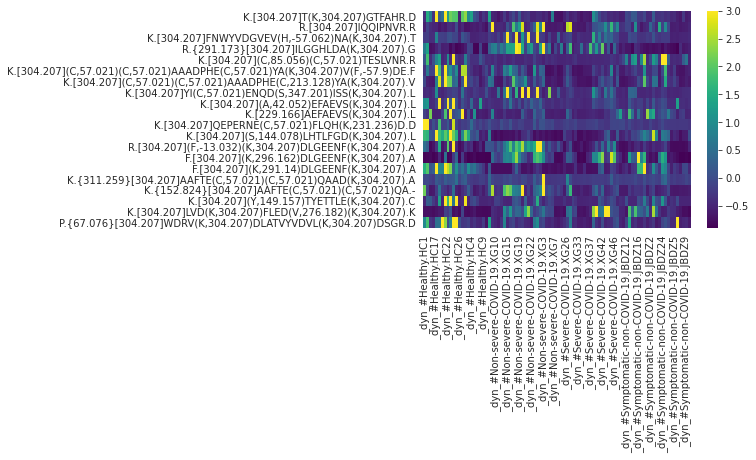

In [23]:
from collections import OrderedDict

#Heat Map
def z_score(df):
    df_std = df.copy()
    for col in df_std.columns:
        df_std[col] = (df_std[col] - df_std[col].mean()) / df_std[col].std()
        df_std[col] = df_std[col].map(lambda x: x if np.isnan(x) else min(3, max(-3, x)))
    
    return df_std

peptides_heatmap = data_processed.copy()
peptides_heatmap = peptides_heatmap.loc[:, list(feature_Kbest)]
peptides_heatmap = z_score(peptides_heatmap)
peptides_heatmap = peptides_heatmap.T

peptides_heatmap_dict = peptides_heatmap.to_dict()
od_peptides_heatmap_dict = OrderedDict(sorted(peptides_heatmap_dict.items()))
peptides_heatmap = pd.DataFrame.from_dict(od_peptides_heatmap_dict)


cmap = sns.color_palette('viridis', as_cmap = True)
with sns.axes_style('white'):
    sns.heatmap(peptides_heatmap, cmap = cmap)

In [24]:
#Protein Assessment
protein_data = data[['Peptide']+["Canonical_proteins"]] #Canonical_proteins
protein_data = protein_data.set_index("Peptide")
protein_data = protein_data[protein_data.index.isin(feature_Kbest)]
protein_data

,Canonical_proteins
Peptide,
"K.[304.207]T(K,304.207)GTFAHR.D",sp|P04114|APOB_HUMAN
R.[304.207]IQQIPNVR.R,sp|Q6UX71|PXDC2_HUMAN
"K.[304.207]FNWYVDGVEV(H,-57.062)NA(K,304.207).T",sp|P01857|IGHG1_HUMAN; sp|P01859|IGHG2_HUMAN; ...
"R.{291.173}[304.207]ILGGHLDA(K,304.207).G",sp|P00738|HPT_HUMAN; sp|P00739|HPTR_HUMAN
"K.[304.207](C,85.056)(C,57.021)TESLVNR.R",sp|P02768|ALBU_HUMAN
"K.[304.207](C,57.021)(C,57.021)AAADPHE(C,57.021)YA(K,304.207)V(F,-57.9)DE.F",sp|P02768|ALBU_HUMAN
"K.[304.207](C,57.021)(C,57.021)AAADPHE(C,213.128)YA(K,304.207).V",sp|P02768|ALBU_HUMAN
"K.[304.207]YI(C,57.021)ENQD(S,347.201)ISS(K,304.207).L",sp|P02768|ALBU_HUMAN
"K.[304.207](A,42.052)EFAEVS(K,304.207).L",sp|P02768|ALBU_HUMAN


In [25]:
from collections import defaultdict

def getAllProteins(proteins):
    proteinDict = {}
    proteinList = []
    listOfProtein =proteins.split(";") 
    for protein in listOfProtein:
        data = protein.split("|")
        if len(data)<2:
            continue
        proteinList.append(data[1])
        proteinDict[data[1]] = protein
    return proteinList, proteinDict

def getPeptideAndProtein(protien_data):
    
    peptideToProteins = defaultdict(list)
    proteinToPeptides = defaultdict(list)

    ProteinsDict = {}

    for index, row in tqdm(protien_data.iterrows()):
        proteins =str(row["Canonical_proteins"]) 
        proteinList, proteinDict = getAllProteins(proteins)
        if len(proteinList)==0:
            continue
        ProteinsDict.update(proteinDict)
        peptideToProteins[index].extend(proteinList)
        for p in proteinList:
            proteinToPeptides[p].append(index)
    return peptideToProteins, proteinToPeptides, ProteinsDict

peptideToProteins, proteinToPeptides, ProteinsDict = getPeptideAndProtein(protein_data)
print("Total protein length",len(proteinToPeptides))

20it [00:00, 11109.27it/s]

Total protein length 10


In [26]:
uniqueProtein = set()

for protein in proteinToPeptides:
    if len(proteinToPeptides[protein])==1 and len(peptideToProteins[proteinToPeptides[protein][0]])==1:
        uniqueProtein.add(protein)
print("Unique protein length",len(uniqueProtein))

includedPeptide = {}

for peptide in peptideToProteins:
    includedPeptide[peptide] = False
    
for protein in uniqueProtein:
    includedPeptide[proteinToPeptides[protein][0]]=True
    
proteinToPeptidesSortedList =  sorted(proteinToPeptides, key = lambda key: -len(proteinToPeptides[key]))

Unique protein length 4


In [27]:
def countMaxPeptideCount(includedPeptide, uniqueProtein):
    maxLen = 0
    maxProtein = ""
    for protein in proteinToPeptidesSortedList:
        if protein in uniqueProtein:
            continue
                
        peptideList = proteinToPeptides[protein]
        count=0
        
        for p in peptideList:
            if includedPeptide[p]==False:
                count+=1
        if count > maxLen:
            maxLen = count 
            maxProtein = protein
    return maxProtein, maxLen

Total = len(includedPeptide)
while Total != sum(includedPeptide.values()):
        protein, length = countMaxPeptideCount(includedPeptide, uniqueProtein)
        peptideList = proteinToPeptides[protein]
        for peptide in peptideList:
            includedPeptide[peptide] = True
        uniqueProtein.add(protein) 

In [28]:
topProtein = {} 
for i in uniqueProtein:
    topProtein[i]=proteinToPeptides[i]
    
topProteinList = sorted(topProtein, key = lambda key: -len(topProtein[key]))#[:10]

pd.DataFrame(topProtein.items(), columns=["Protein", "Peptide"]).style

,Protein,Peptide
0,P01857,"['K.[304.207]FNWYVDGVEV(H,-57.062)NA(K,304.207).T']"
1,P01009,"['K.[304.207]LVD(K,304.207)FLED(V,276.182)(K,304.207).K']"
2,P04114,"['K.[304.207]T(K,304.207)GTFAHR.D']"
3,P00738,"['R.{291.173}[304.207]ILGGHLDA(K,304.207).G']"
4,Q6UX71,['R.[304.207]IQQIPNVR.R']
5,P02768,"['K.[304.207](C,85.056)(C,57.021)TESLVNR.R', 'K.[304.207](C,57.021)(C,57.021)AAADPHE(C,57.021)YA(K,304.207)V(F,-57.9)DE.F', 'K.[304.207](C,57.021)(C,57.021)AAADPHE(C,213.128)YA(K,304.207).V', 'K.[304.207]YI(C,57.021)ENQD(S,347.201)ISS(K,304.207).L', 'K.[304.207](A,42.052)EFAEVS(K,304.207).L', 'K.[229.166]AEFAEVS(K,304.207).L', 'K.[304.207]QEPERNE(C,57.021)FLQH(K,231.236)D.D', 'K.[304.207](S,144.078)LHTLFGD(K,304.207).L', 'R.[304.207](F,-13.032)(K,304.207)DLGEENF(K,304.207).A', 'F.[304.207](K,296.162)DLGEENF(K,304.207).A', 'F.[304.207](K,291.14)DLGEENF(K,304.207).A', 'K.{311.259}[304.207]AAFTE(C,57.021)(C,57.021)QAAD(K,304.207).A', 'K.{152.824}[304.207]AAFTE(C,57.021)(C,57.021)QA.-']"
6,P02647,"['P.{67.076}[304.207]WDRV(K,304.207)DLATVYVDVL(K,304.207)DSGR.D']"


In [29]:
all_protein_data = data[['Peptide']+["Canonical_proteins"]]
all_protein_data = all_protein_data.set_index("Peptide")
allPeptideToProteins, allProteinToPeptides, allProteinsDict = getPeptideAndProtein(all_protein_data)

101461it [00:07, 13278.35it/s]


In [30]:
Tcount = len(feature_X)
proteinPercentage = {}
for tpl in topProteinList:
    count = 0
    allPeptide = allProteinToPeptides[tpl]
    for p in feature_X:
        if p in allPeptide:
            count+=1
    proteinPercentage[tpl] = (count/Tcount)

pd.DataFrame(proteinPercentage.items(), columns=["Protein", "Percentage"]).style 

,Protein,Percentage
0,P02768,0.369592
1,P01857,0.011125
2,P01009,0.006180
3,P04114,0.032138
4,P00738,0.070457
5,Q6UX71,0.001236
6,P02647,0.034611


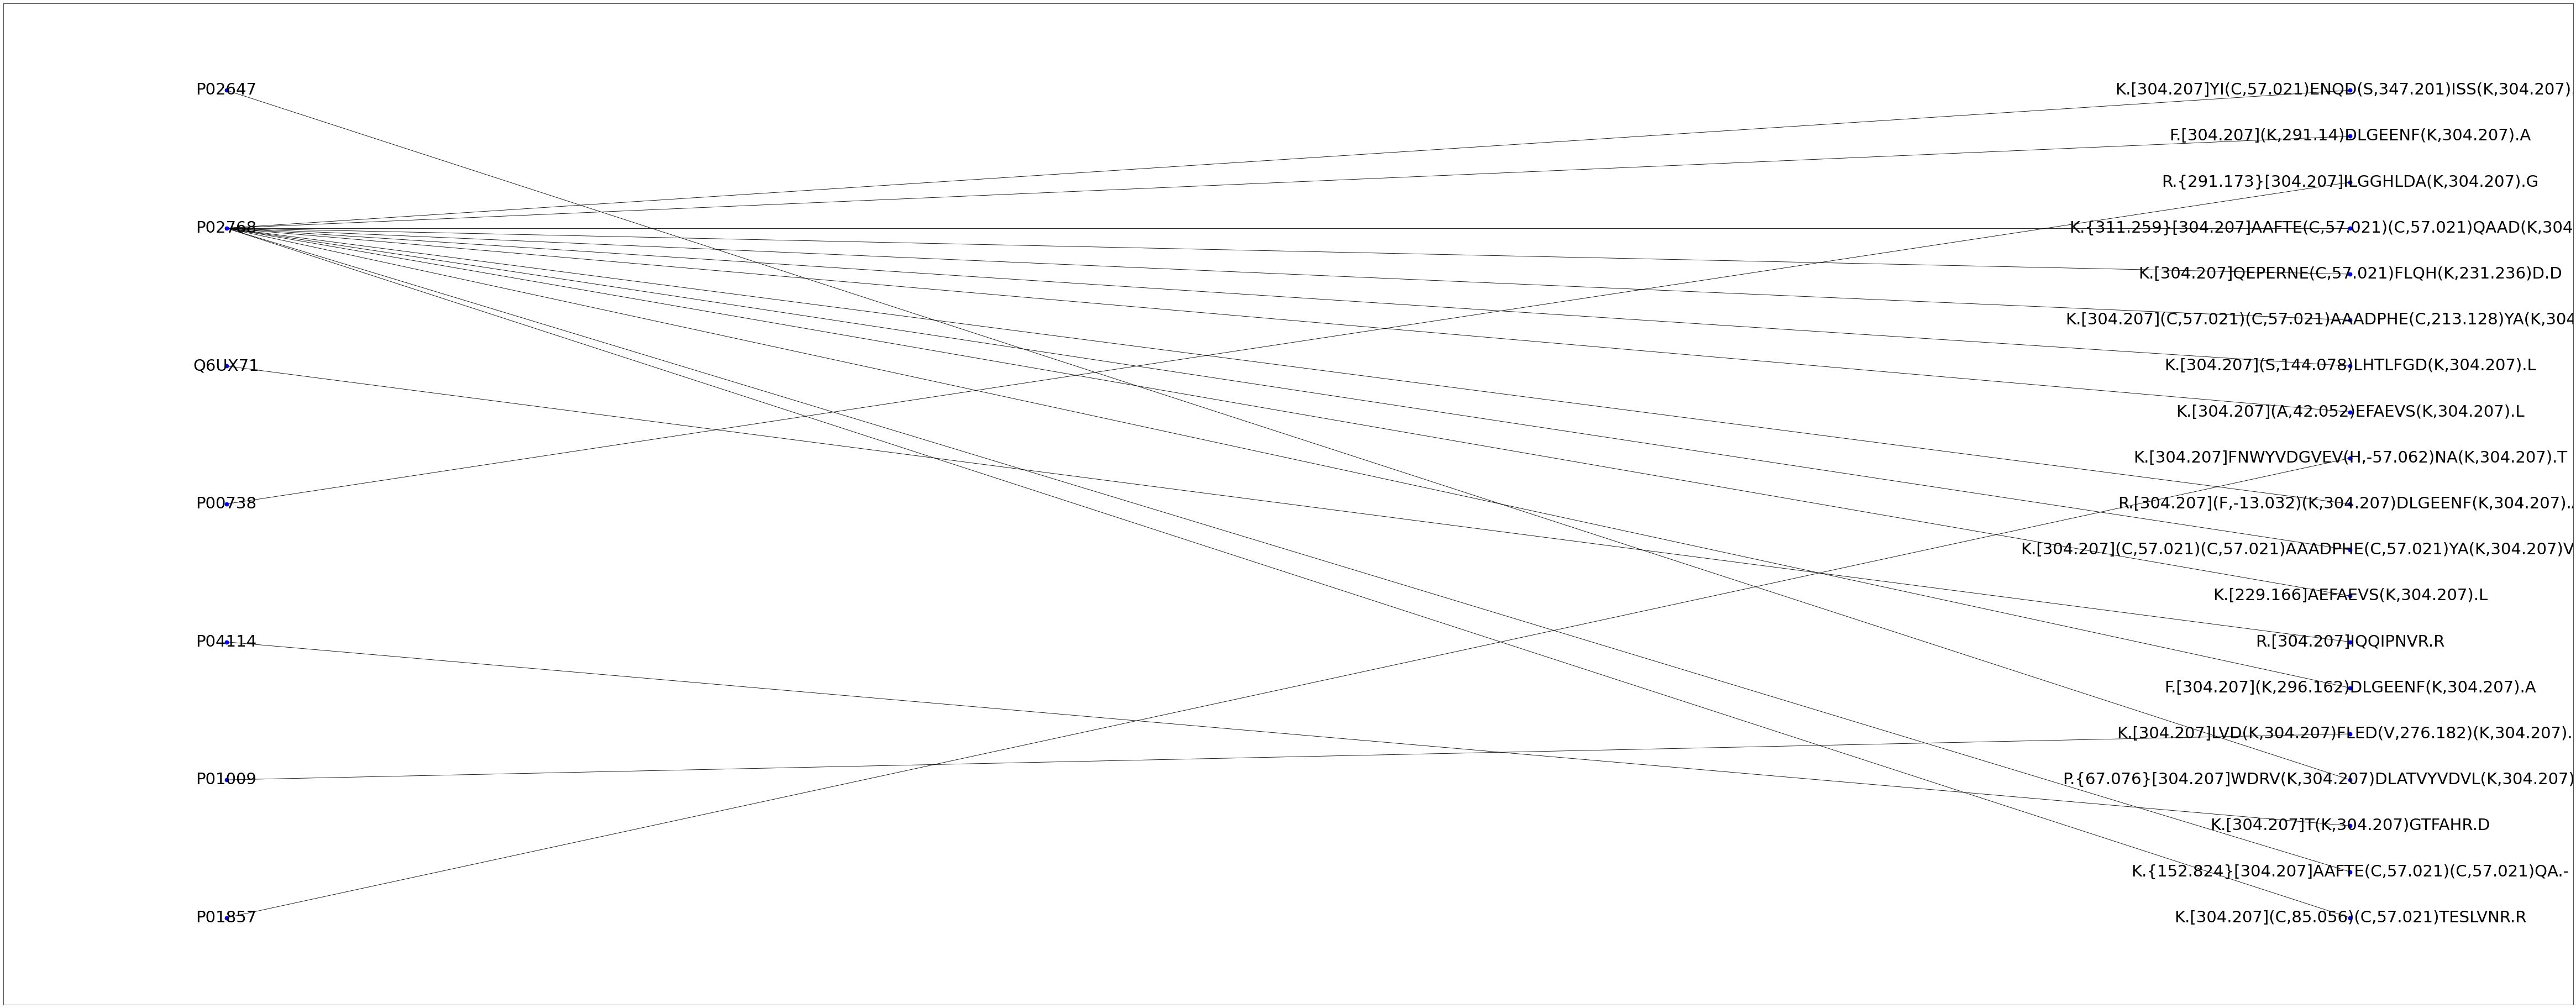

In [31]:
#Bipartite graph

from networkx.algorithms import bipartite
import networkx as nx
import matplotlib.pyplot as plt

topPeptideList = list(peptideToProteins.keys())

G = nx.Graph()
G.add_nodes_from(topProteinList, bipartite=0)
G.add_nodes_from(topPeptideList,bipartite=1)

edge = []
for i in topProtein:
    for j in topProtein[i]:
        edge.append((i,j))
        
G.add_edges_from(edge)
fig = plt.figure(1, figsize=(100, 40),dpi=60)
nx.draw_networkx(G, pos = nx.drawing.layout.bipartite_layout(G,topProteinList),node_size=70, node_color ="blue",font_size =35)

In [32]:
#Variant level Assessment
unmodified_peptide_data = data[['Peptide']+["Unmodified_sequence"]] 
unmodified_peptide_data = unmodified_peptide_data.set_index("Peptide")

unmodifiedToPeptides = defaultdict(list)

for index, row in tqdm(unmodified_peptide_data.iterrows()):
    unmodifiedToPeptides[row["Unmodified_sequence"]].append(index)
    
topUnmodified_peptide_data=unmodified_peptide_data[unmodified_peptide_data.index.isin(feature_Kbest)]
topUnmodifiedToPeptides = topUnmodified_peptide_data["Unmodified_sequence"]

unmodifiedPercentage = {}
for i in list(topUnmodifiedToPeptides):
    count=0
    unmodifiedList = unmodifiedToPeptides[i]
    for j in unmodifiedList:
        if j in feature_X:
            count +=1
    unmodifiedPercentage[i] = (count/Tcount)

pd.DataFrame(unmodifiedPercentage.items(), columns=["Unmodified Peptide", "Percentage"]).style

101461it [00:06, 15444.54it/s]


,Unmodified Peptide,Percentage
0,.TKGTFAHR.,0.001236
1,.IQQIPNVR.,0.001236
2,.FNWYVDGVEVHNAK.,0.002472
3,.ILGGHLDAK.,0.003708
4,.CCTESLVNR.,0.003708
5,.CCAAADPHECYAKVFDE.,0.001236
6,.CCAAADPHECYAK.,0.002472
7,.YICENQDSISSK.,0.009889
8,.AEFAEVSK.,0.008653
9,.QEPERNECFLQHKD.,0.001236
